In [1]:
import torch

from gaussiansplatting.scene.gaussian_model import GaussianModel
from gaussiansplatting.scene import Scene
from gaussiansplatting.gaussian_renderer import render

from argparse import ArgumentParser
from gaussiansplatting.arguments import ModelParams, PipelineParams

from argparse import ArgumentParser, Namespace

import os

def get_combined_args(parser : ArgumentParser, model_path):
    # cmdlne_string = sys.argv[1:]
    # cfgfile_string = "Namespace()"
    cmdlne_string = ['--model_path', model_path]
    cfgfile_string = "Namespace()"
    args_cmdline = parser.parse_args(cmdlne_string)

    try:
        cfgfilepath = os.path.join(model_path, "cfg_args")
        print("Looking for config file in", cfgfilepath)
        with open(cfgfilepath) as cfg_file:
            print("Config file found: {}".format(cfgfilepath))
            cfgfile_string = cfg_file.read()
    except TypeError:
        print("Config file not found at")
        pass
    args_cfgfile = eval(cfgfile_string)

    merged_dict = vars(args_cfgfile).copy()
    for k,v in vars(args_cmdline).items():
        if v != None:
            merged_dict[k] = v
    return Namespace(**merged_dict)

parser = ArgumentParser(description="Testing script parameters")
model = ModelParams(parser, sentinel=True)
pipeline = PipelineParams(parser)
# op = OptimizationParams(parser)
parser.add_argument("--iteration", default=-1, type=int)
parser.add_argument("--skip_train", action="store_true")
parser.add_argument("--skip_test", action="store_true")
parser.add_argument("--quiet", action="store_true")

parser.add_argument("--threshold", default=0.7, type=float, help='threshold of label voting')
parser.add_argument("--gd_interval", default=20, type=int, help='interval of performing gaussian decomposition')

## choose your trained 3D-GS model path
model_path = '/home/xu_hu/projects/GS/SA-GS/outputs/pinecone'
args = get_combined_args(parser, model_path)

# Initialize system state (RNG)
# safe_state(args.quiet)

# 3D gaussians
dataset = model.extract(args)
dataset.model_path = args.model_path
gaussians = GaussianModel(dataset.sh_degree)
scene = Scene(dataset, gaussians, load_iteration=args.iteration, shuffle=False)

cameras = scene.getTrainCameras()

dataset.white_background = True
bg_color = [1,1,1] if dataset.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

xyz = gaussians.get_xyz

Looking for config file in /home/xu_hu/projects/GS/SA-GS/outputs/pinecone/cfg_args
Config file found: /home/xu_hu/projects/GS/SA-GS/outputs/pinecone/cfg_args
Loading trained model at iteration 30000
Reading camera 99/99
Loading Training Cameras
Loading Test Cameras


In [2]:
import torch.nn.functional as F
import torchvision.transforms.functional as func

from seg_utils import conv2d_matrix, compute_ratios, update

def get_3d_prompts(prompts_2d, point_image, xyz, depth=None):
    r = 4
    x_range = torch.arange(prompts_2d[0] - r, prompts_2d[0] + r)
    y_range = torch.arange(prompts_2d[1] - r, prompts_2d[1] + r)
    x_grid, y_grid = torch.meshgrid(x_range, y_range)
    neighbors = torch.stack([x_grid, y_grid], dim=2).reshape(-1, 2).to("cuda")
    prompts_index = [torch.where((point_image == p).all(dim=1))[0] for p in neighbors]
    indexs = []
    for index in prompts_index:
        if index.nelement() > 0:
            indexs.append(index)
    indexs = torch.unique(torch.cat(indexs, dim=0))
    indexs_depth = depth[indexs]
    valid_depth = indexs_depth[indexs_depth > 0]
    _, sorted_indices = torch.sort(valid_depth)
    valid_indexs = indexs[depth[indexs] > 0][sorted_indices[0]]
    
    return xyz[valid_indexs][:3].unsqueeze(0)

## Given 1st view point prompts, find corresponding 3D Gaussian point prompts
def generate_3d_prompts(xyz, viewpoint_camera, prompts_2d):
    w2c_matrix = viewpoint_camera.world_view_transform
    full_matrix = viewpoint_camera.full_proj_transform
    # project to image plane
    xyz = F.pad(input=xyz, pad=(0, 1), mode='constant', value=1)
    p_hom = (xyz @ full_matrix).transpose(0, 1)  # N, 4 -> 4, N
    p_w = 1.0 / (p_hom[-1, :] + 0.0000001)
    p_proj = p_hom[:3, :] * p_w
    # project to camera space
    p_view = (xyz @ w2c_matrix[:, :3]).transpose(0, 1)  # N, 3 -> 3, N
    depth = p_view[-1, :].detach().clone()
    valid_depth = depth >= 0

    h = viewpoint_camera.image_height
    w = viewpoint_camera.image_width

    point_image = 0.5 * ((p_proj[:2] + 1) * torch.tensor([w, h]).unsqueeze(-1).to(p_proj.device) - 1)
    point_image = point_image.detach().clone()
    point_image = torch.round(point_image.transpose(0, 1)).long()

    prompts_2d = torch.tensor(prompts_2d).to("cuda")
    prompts_3d = []
    for i in range(prompts_2d.shape[0]):
        prompts_3d.append(get_3d_prompts(prompts_2d[i], point_image, xyz, depth))
    prompts_3D = torch.cat(prompts_3d, dim=0)

    return prompts_3D

## Project 3D points to 2D plane
def porject_to_2d(viewpoint_camera, points3D):
    full_matrix = viewpoint_camera.full_proj_transform  # w2c @ K 
    # project to image plane
    if points3D.shape[-1] != 4:
        points3D = F.pad(input=points3D, pad=(0, 1), mode='constant', value=1)
    p_hom = (points3D @ full_matrix).transpose(0, 1)  # N, 4 -> 4, N   -1 ~ 1
    p_w = 1.0 / (p_hom[-1, :] + 0.0000001)
    p_proj = p_hom[:3, :] * p_w

    h = viewpoint_camera.image_height
    w = viewpoint_camera.image_width

    point_image = 0.5 * ((p_proj[:2] + 1) * torch.tensor([w, h]).unsqueeze(-1).to(p_proj.device) - 1) # image plane
    point_image = point_image.detach().clone()
    point_image = torch.round(point_image.transpose(0, 1))

    return point_image

## Single view assignment
def mask_inverse(xyz, viewpoint_camera, sam_mask):
    w2c_matrix = viewpoint_camera.world_view_transform
    # project to camera space
    xyz = F.pad(input=xyz, pad=(0, 1), mode='constant', value=1)
    p_view = (xyz @ w2c_matrix[:, :3]).transpose(0, 1)  # N, 3 -> 3, N
    depth = p_view[-1, :].detach().clone()
    valid_depth = depth >= 0

    h = viewpoint_camera.image_height
    w = viewpoint_camera.image_width
    

    if sam_mask.shape[0] != h or sam_mask.shape[1] != w:
        sam_mask = func.resize(sam_mask.unsqueeze(0), (h, w), antialias=True).squeeze(0).long()
    else:
        sam_mask = sam_mask.long()

    point_image = porject_to_2d(viewpoint_camera, xyz)
    point_image = point_image.long()

    # 判断x,y是否在图像范围之内
    valid_x = (point_image[:, 0] >= 0) & (point_image[:, 0] < w)
    valid_y = (point_image[:, 1] >= 0) & (point_image[:, 1] < h)
    valid_mask = valid_x & valid_y & valid_depth
    point_mask = torch.full((point_image.shape[0],), -1).to("cuda")

    point_mask[valid_mask] = sam_mask[point_image[valid_mask, 1], point_image[valid_mask, 0]]
    indices_mask = torch.where(point_mask == 1)[0]

    return point_mask, indices_mask

## Multi-view label voting
def ensemble(multiview_masks, threshold=0.7):
    # threshold = 0.7
    multiview_masks = torch.cat(multiview_masks, dim=1)
    vote_labels,_ = torch.mode(multiview_masks, dim=1)
    # # select points with score > threshold 
    matches = torch.eq(multiview_masks, vote_labels.unsqueeze(1))
    ratios = torch.sum(matches, dim=1) / multiview_masks.shape[1]
    ratios_mask = ratios > threshold
    labels_mask = (vote_labels == 1) & ratios_mask
    indices_mask = torch.where(labels_mask)[0].detach().cpu()

    return vote_labels, indices_mask

## Gaussian Decomposition
def gaussian_decomp(gaussians, viewpoint_camera, input_mask, indices_mask):
    xyz = gaussians.get_xyz
    point_image = porject_to_2d(viewpoint_camera, xyz)

    conv2d = conv2d_matrix(gaussians, viewpoint_camera, indices_mask, device="cuda")
    height = viewpoint_camera.image_height
    width = viewpoint_camera.image_width
    index_in_all, ratios, dir_vector = compute_ratios(conv2d, point_image, indices_mask, input_mask, height, width)

    decomp_gaussians = update(gaussians, viewpoint_camera, index_in_all, ratios, dir_vector)

    return decomp_gaussians
    

/home/xu_hu/anaconda3/envs/seg_gs/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prepare SAM predictor

In [3]:
import numpy as np
from segment_anything import (SamAutomaticMaskGenerator, SamPredictor,
                              sam_model_registry)
from seg_utils import grounding_dino_prompt

SAM_ARCH = 'vit_h'
SAM_CKPT_PATH = '../gaussiansplatting/dependencies/sam_ckpt/sam_vit_h_4b8939.pth'

model_type = SAM_ARCH
sam = sam_model_registry[model_type](checkpoint=SAM_CKPT_PATH).to('cuda')
predictor = SamPredictor(sam)

# text guided
def text_prompting(image, text, id):
    input_boxes = grounding_dino_prompt(image, text)

    boxes = torch.tensor(input_boxes)[0:1].cuda()
    transformed_boxes = predictor.transform.apply_boxes_torch(boxes, image.shape[:2])
    masks,  _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=True,
    )

    masks = masks[0].cpu().numpy()
    return_mask = (masks[id, :, :, None]*255).astype(np.uint8)
    return return_mask / 255

# point guided
def self_prompt(point_prompts, sam_feature, id):
    input_point = point_prompts.detach().cpu().numpy()
    # input_point = input_point[::-1]
    input_label = np.ones(len(input_point))

    predictor.features = sam_feature
    masks, _, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    # return_mask = (masks[ :, :, 0]*255).astype(np.uint8)
    return_mask = (masks[id, :, :, None]*255).astype(np.uint8)

    return return_mask / 255

In [4]:
import cv2
import numpy as np
from tqdm import tqdm

sam_features = {}
render_images = {}
print("Prepocessing: extracting SAM features...")
for view in tqdm(cameras):
    image_name = view.image_name
    render_pkg = render(view, gaussians, pipeline, background)

    render_image = render_pkg["render"].permute(1, 2, 0).detach().cpu().numpy()
    render_image = (255 * np.clip(render_image, 0, 1)).astype(np.uint8)

    predictor.set_image(render_image)
    sam_features[image_name] = predictor.features

Prepocessing: extracting SAM features...


100%|██████████| 99/99 [00:42<00:00,  2.31it/s]


## Select point prompts given the first view

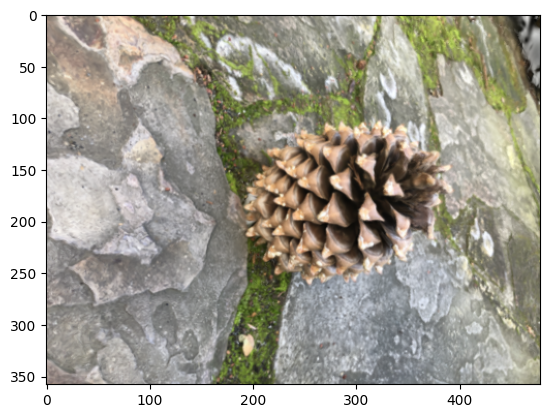

In [5]:
from matplotlib import pyplot as plt

# first view
idx = 0
view = cameras[idx]
render_pkg = render(view, gaussians, pipeline, background)

render_image = render_pkg["render"].permute(1, 2, 0).detach().cpu().numpy()
render_image = (255 * np.clip(render_image, 0, 1)).astype(np.uint8)

plt.imshow(render_image)

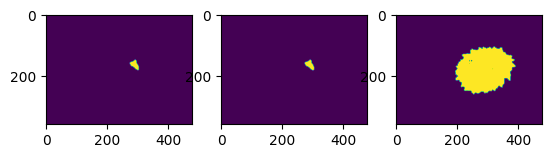

In [6]:
## can select input points from 1st view
input_point = (np.asarray([[300, 180]])).astype(np.int32)
# input_point = (np.asarray([[1200, 700]])).astype(np.int32)
input_label = np.ones(len(input_point))

predictor.set_image(render_image)
with torch.no_grad():
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )

plt.subplot(1,3,1)
plt.imshow(masks[0])
plt.subplot(1,3,2)
plt.imshow(masks[1])
plt.subplot(1,3,3)
plt.imshow(masks[2])

## Start Segmentation

In [7]:
print("Start Segmentation...")

from plyfile import PlyData, PlyElement
import copy

def save_gs(pc, indices_mask, save_path):
    
    xyz = pc._xyz.detach().cpu()[indices_mask].numpy()
    normals = np.zeros_like(xyz)
    f_dc = pc._features_dc.detach().transpose(1, 2).flatten(start_dim=1).contiguous().cpu()[indices_mask].numpy()
    f_rest = pc._features_rest.detach().transpose(1, 2).flatten(start_dim=1).contiguous().cpu()[indices_mask].numpy()
    opacities = pc._opacity.detach().cpu()[indices_mask].numpy()
    scale = pc._scaling.detach().cpu()[indices_mask].numpy()
    rotation = pc._rotation.detach().cpu()[indices_mask].numpy()

    dtype_full = [(attribute, 'f4') for attribute in pc.construct_list_of_attributes()]

    elements = np.empty(xyz.shape[0], dtype=dtype_full)
    attributes = np.concatenate((xyz, normals, f_dc, f_rest, opacities, scale, rotation), axis=1)
    elements[:] = list(map(tuple, attributes))
    el = PlyElement.describe(elements, 'vertex')
    PlyData([el]).write(save_path)

mask_id = 2

# generate 3D prompts
xyz = gaussians.get_xyz
prompts_3d = generate_3d_prompts(xyz, cameras[idx], input_point)


multiview_masks = []
sam_masks = []
for i, view in enumerate(cameras):
    image_name = view.image_name
    render_pkg = render(view, gaussians, pipeline, background)

    render_image = render_pkg["render"].permute(1, 2, 0).detach().cpu().numpy()
    render_image = (255 * np.clip(render_image, 0, 1)).astype(np.uint8)

    # project 3d prompts to 2d prompts
    prompts_2d = porject_to_2d(view, prompts_3d)

    # sam prediction
    sam_mask = self_prompt(prompts_2d, sam_features[image_name], mask_id)
    if len(sam_mask.shape) != 2:
        sam_mask = torch.from_numpy(sam_mask).squeeze(-1).to("cuda")
    else:
        sam_mask = torch.from_numpy(sam_mask).to("cuda")
    sam_mask = sam_mask.long()
    sam_masks.append(sam_mask)
    
    # mask assignment to gaussians
    point_mask, indices_mask = mask_inverse(xyz, view, sam_mask)

    multiview_masks.append(point_mask.unsqueeze(-1))

    # # gaussian decomposition as an intermediate process
    # if args.gd_interval != -1 \
    #                     and i % args.gd_interval == 0:  # 
    #     gaussians = gaussian_decomp(gaussians, view, sam_mask, indices_mask)

# multi-view label ensemble
_, final_mask = ensemble(multiview_masks, threshold=args.threshold)

# save before gaussian decomposition
save_path = os.path.join(model_path, 'point_cloud/iteration_30000/point_cloud_seg.ply')
save_gs(gaussians, final_mask, save_path)


Start Segmentation...


/home/xu_hu/anaconda3/envs/seg_gs/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
# if gaussian decomposition as a post-process module
for i, view in enumerate(cameras):
    if args.gd_interval != -1 and i % args.gd_interval == 0:
        input_mask = sam_masks[i]
        gaussians = gaussian_decomp(gaussians, view, input_mask, final_mask.to('cuda'))

# save after gaussian decomposition
save_gd_path = os.path.join(model_path, 'point_cloud/iteration_30000/point_cloud_seg_gd.ply')
save_gs(gaussians, final_mask, save_gd_path)

In [9]:
# render object images

seg_gaussians = GaussianModel(dataset.sh_degree)
seg_gaussians.load_ply(save_gd_path)

obj_save_path = os.path.join(model_path, 'obj_images')

if not os.path.exists(obj_save_path):
    os.mkdir(obj_save_path)

for idx in range(len(cameras)):
    image_name = cameras[idx].image_name
    view = cameras[idx]

    render_pkg = render(view, seg_gaussians, pipeline, background)
    # get sam output mask
    render_image = render_pkg["render"].permute(1, 2, 0).detach().cpu().numpy()
    render_image = (255 * np.clip(render_image, 0, 1)).astype(np.uint8)
    render_image = cv2.cvtColor(render_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(obj_save_path, '{}.jpg'.format(image_name)), render_image)
